In [ ]:
import numpy as np


class RNN:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None
    
    def forward(self, x, h_prev):
        Wx,Wh,b=self.params
        t=np.matmul(h_prev,Wh)+np.matmul(x,Wx)+b
        h_next=np.tanh(t)

        self.cache=(x,h_prev,h_next)
        return h_next

    def backward(self,dh_next):
        Wx,Wh,b=self.params
        x,h_prev,h_next=self.cache

        dt=dh_next*(1-h_next**2)
        db=np.sum(dt,axis=0)

In [ ]:
import numpy as np


#우리는 TBPTT를 본다. 
class TimeRNN:
    def __init__(self,Wx,Wh,b, stateful=False):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh), np.zeros_like(b)]
        self.layers=None

        self.h, self.dh=None, None
        self.stateful=stateful

    def set_state(self,h):
        self.h=h

    def reset_state(self):
        self.h=None
    
    def forward(self,xs):
        Wx,Wh,b=self.params
        N,T,D=xs.shape
        D,H=Wx.shape

        self.layers=[]
        hs=np.empty((N,T,H), dtype='f')

        if not self.stateful or self.h is None:             #self.stateful이 False거나 self.h가 None이 False일 때 
            self.h==np.zeros((N,H), dtype='f')

        for t in range(T):
            layer=RNN(*self.params)
            self.h=layer.forward(xs[:,t,:], self.h)
            hs[:,t,:]=self.h
            self.layers.append(layer)

            return hs
        
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):      # Wx, Wh, db가 각각 합산되는거임.
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh                                    #우리seq2seq에 사용하는 TBPTT를 보지만, 추후에 나올 기 위해 이전 시각의 은닉 상태 기울기는 남겨놓자.
        
        return dxs

In [4]:
ts = np.array([[[1, 0, 0, 0, 0, 0]],  # 'you'
               [[0, 1, 0, 0, 0, 0]],  # 'say'
               [[0, 0, 1, 0, 0, 0]],  # 'goodbye'
               [[0, 0, 0, 1, 0, 0]],  # 'and'
               [[0, 0, 0, 0, 1, 0]],  # 'i'
               [[0, 0, 0, 0, 0, 1]]]) # 'hello'
if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
    ts = ts.argmax(axis=2)

print(ts)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [12]:
ys = np.array([[0.161, 0.193, 0.212, 0.161, 0.161, 0.212],  # 'you'에 대한 예측 확률
               [0.161, 0.264, 0.161, 0.161, 0.161, 0.212],  # 'say'에 대한 예측 확률
               [0.161, 0.161, 0.264, 0.161, 0.161, 0.212],  # 'goodbye'에 대한 예측 확률
               [0.161, 0.161, 0.161, 0.264, 0.161, 0.212],  # 'and'에 대한 예측 확률
               [0.161, 0.161, 0.161, 0.161, 0.264, 0.212],  # 'i'에 대한 예측 확률
               [0.161, 0.161, 0.161, 0.161, 0.161, 0.264]]) # 'hello'에 대한 예측 확률

#np.arange(6)

ys[np.arange(6), np.arange(6)]

array([0.161, 0.264, 0.264, 0.264, 0.264, 0.264])

In [30]:
#참고)

a=1
b=2
c=3
d=4
params = []  # 빈 리스트로 초기화
layer1_params = [a, b]  # 첫 번째 계층의 파라미터 리스트
layer2_params = [c, d]  # 두 번째 계층의 파라미터 리스트

params += layer1_params  # layer1_params의 각 요소를 하나씩 추가
params += layer2_params  # layer2_params의 각 요소를 하나씩 추가

params

[1, 2, 3, 4]

In [31]:
#참고2

a=1
b=2
c=3
d=4

params = []  # 빈 리스트로 초기화
layer1_params = [a,b]  # 첫 번째 계층의 파라미터 리스트
layer2_params = [c,d]  # 두 번째 계층의 파라미터 리스트
params += [layer1_params]  # self.params에 layer1_params를 추가 (리스트 안에 리스트)
params += [layer2_params]  # self.params에 layer2_params를 추가 (리스트 안에 리스트)

params

[[1, 2], [3, 4]]

In [ ]:
# chap05/simple_rnnlm.py
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화 (Xavier initialization)
        embed_W = (rn(V, D) / 100).astype('f')          # V: 단어 집합의 크기, D: 단어 벡터의 차원 H: 은닉상태 크기.
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.   
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params         #가중치들을 추가해줌.
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 351.99
| 에폭 2 | 퍼플렉서티 237.27
| 에폭 3 | 퍼플렉서티 218.85
| 에폭 4 | 퍼플렉서티 211.92
| 에폭 5 | 퍼플렉서티 203.64
| 에폭 6 | 퍼플렉서티 201.45
| 에폭 7 | 퍼플렉서티 198.50
| 에폭 8 | 퍼플렉서티 196.19
| 에폭 9 | 퍼플렉서티 190.79
| 에폭 10 | 퍼플렉서티 192.64
| 에폭 11 | 퍼플렉서티 188.33
| 에폭 12 | 퍼플렉서티 192.60
| 에폭 13 | 퍼플렉서티 191.04
| 에폭 14 | 퍼플렉서티 190.57
| 에폭 15 | 퍼플렉서티 190.69
| 에폭 16 | 퍼플렉서티 186.77
| 에폭 17 | 퍼플렉서티 184.31
| 에폭 18 | 퍼플렉서티 180.93
| 에폭 19 | 퍼플렉서티 182.86
| 에폭 20 | 퍼플렉서티 184.31
| 에폭 21 | 퍼플렉서티 181.70
| 에폭 22 | 퍼플렉서티 178.14
| 에폭 23 | 퍼플렉서티 175.44
| 에폭 24 | 퍼플렉서티 176.58
| 에폭 25 | 퍼플렉서티 174.19
| 에폭 26 | 퍼플렉서티 175.10
| 에폭 27 | 퍼플렉서티 168.39
| 에폭 28 | 퍼플렉서티 167.29
| 에폭 29 | 퍼플렉서티 167.64
| 에폭 30 | 퍼플렉서티 159.81
| 에폭 31 | 퍼플렉서티 160.24
| 에폭 32 | 퍼플렉서티 157.32
| 에폭 33 | 퍼플렉서티 154.28
| 에폭 34 | 퍼플렉서티 149.91
| 에폭 35 | 퍼플렉서티 148.97
| 에폭 36 | 퍼플렉서티 144.05
| 에폭 37 | 퍼플렉서티 139.89
| 에폭 38 | 퍼플렉서티 136.79
| 에폭 39 | 퍼플렉서티 130.13
| 에폭 40 | 퍼플렉서티 126.10
| 에폭 41 | 퍼플렉서티 125.86
| 에폭 42 | 퍼플렉서티 119.36
| 에폭 43 | 퍼플렉서티 113

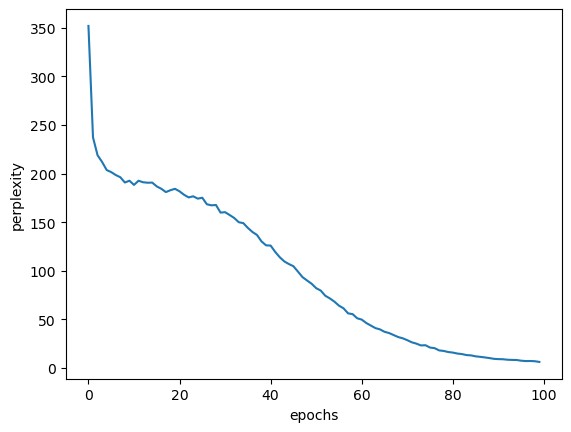

In [ ]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10                 #한개의 batch안에는 문장이 들어감.
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)           # 총데이터 수/한_미니배치에서_처리하는_데이터수
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size               #p209의 그 오프셋임.
offsets = [i * jump for i in range(batch_size)]      #0, 99, 198 ...

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')          
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            #열별로 값을 채워준다.
            #예를들어
            #batch_x의 [0,0],[99,0],[197,0]... 그러고 [0,1],[99,1],[197,1]....
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]  # time index가 4가 되고 나서 미니배치가 바뀜. 그러고는 xs[5]~xs[9]까지 계산되고 다시 미니배치 바뀜.
                batch_t[i, t] = ts[(offset + time_idx) % data_size]  # 미니배치가 바뀔 때 offset의 형태가 어떻게 바뀌는 지는 209페이지를 다시 읽어보자.
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.95
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 386.57
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 264.36
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 221.34
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.69
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 208.64
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.51
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.10
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.37
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.24
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.17
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.40
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.60
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.32
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.10
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.87
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.34
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 185.89
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 183.25
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 183.54
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.92
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.

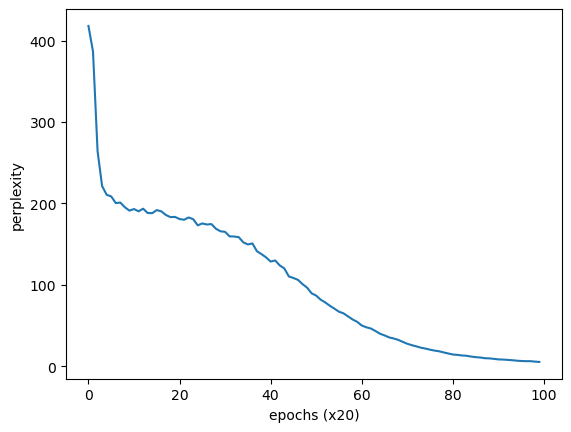

In [33]:
# chap05/train.py
%matplotlib inline
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()